# 문장 토큰 단위 분류 모델 학습

### 1. CPU 및 GPU 환경설정

In [1]:
import torch
import torch
import random
import numpy as np
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.get_device_name(0)

'CUDA GPU'

### 2. 데이터셋

### 한국해양대학교 자연어처리 연구실 NER 데이터 셋

In [4]:
!git clone https://github.com/kmounlp/NER.git

fatal: destination path 'NER' already exists and is not an empty directory.


In [5]:
import os
import glob

In [6]:
file_list = []

In [7]:
for x in os.walk('NER/'):
    for y in glob.glob(os.path.join(x[0], '*_NER.txt')):    # ner.*, *_NER.txt
        file_list.append(y)

In [8]:
file_list = sorted(file_list)

In [9]:
for file_path in file_list:
    print(file_path)

NER/말뭉치 - 형태소_개체명/00002_NER.txt
NER/말뭉치 - 형태소_개체명/00003_NER.txt
NER/말뭉치 - 형태소_개체명/00004_NER.txt
NER/말뭉치 - 형태소_개체명/00005_NER.txt
NER/말뭉치 - 형태소_개체명/00006_NER.txt
NER/말뭉치 - 형태소_개체명/00007_NER.txt
NER/말뭉치 - 형태소_개체명/00008_NER.txt
NER/말뭉치 - 형태소_개체명/00009_NER.txt
NER/말뭉치 - 형태소_개체명/00010_NER.txt
NER/말뭉치 - 형태소_개체명/00011_NER.txt
NER/말뭉치 - 형태소_개체명/00012_NER.txt
NER/말뭉치 - 형태소_개체명/00013_NER.txt
NER/말뭉치 - 형태소_개체명/00014_NER.txt
NER/말뭉치 - 형태소_개체명/00015_NER.txt
NER/말뭉치 - 형태소_개체명/00016_NER.txt
NER/말뭉치 - 형태소_개체명/00017_NER.txt
NER/말뭉치 - 형태소_개체명/00018_NER.txt
NER/말뭉치 - 형태소_개체명/00019_NER.txt
NER/말뭉치 - 형태소_개체명/00020_NER.txt
NER/말뭉치 - 형태소_개체명/00021_NER.txt
NER/말뭉치 - 형태소_개체명/00022_NER.txt
NER/말뭉치 - 형태소_개체명/00023_NER.txt
NER/말뭉치 - 형태소_개체명/00024_NER.txt
NER/말뭉치 - 형태소_개체명/00025_NER.txt
NER/말뭉치 - 형태소_개체명/00026_NER.txt
NER/말뭉치 - 형태소_개체명/00027_NER.txt
NER/말뭉치 - 형태소_개체명/00028_NER.txt
NER/말뭉치 - 형태소_개체명/00029_NER.txt
NER/말뭉치 - 형태소_개체명/00030_NER.txt
NER/말뭉치 - 형태소_개체명/00031_NER.txt
NER/말뭉치 - 형태소_개체명/00032_NER.txt
NER/말뭉치 

### NAVER NLP Challenge 2018 NER 데이터셋

In [10]:
!pip install korpora

from Korpora import Korpora
corpus = Korpora.load("naver_changwon_ner")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 57 kB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 32.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : 네이버 + 창원대
    Repository : https://github.com/naver/nlp-challenge/tree/master/missions/ner
    References : http://air.c

[naver_changwon_ner] download train_data: 16.9MB [00:01, 13.9MB/s]                            


### 3. 허깅페이스 트랜스포머 설치

In [11]:
!pip install transformers==4.5.1

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.1 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 35.7 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 4. 데이터셋 샘플

In [13]:
#한국 해양대학교 데이터셋
from pathlib import Path

file_path = file_list[0]
file_path = Path(file_path)
raw_text = file_path.read_text().strip()

In [14]:
print(raw_text[0:1000])

## 1
## 오에 겐자부로는 일본 현대문학의 초석을 놓은 것으로 평가받는 작가 나쓰메 소세키(1867~1916)의 대표작 ‘마음’에 담긴 군국주의적 요소, 야스쿠니 신사 참배 행위까지 소설의 삽화로 동원하며 일본 사회의 ‘비정상성’을 문제 삼는다.
## <오에 겐자부로:PER>는 <일본:LOC> 현대문학의 초석을 놓은 것으로 평가받는 작가 <나쓰메 소세키:PER>(<1867~1916:DUR>)의 대표작 ‘<마음:POH>’에 담긴 군국주의적 요소, <야스쿠니 신사:ORG> 참배 행위까지 소설의 삽화로 동원하며 <일본:ORG> 사회의 ‘비정상성’을 문제 삼는다.
오에	오에	NNG	B-PER
_	_	_	I-PER
겐자부로	겐자부로	NNP	I-PER
는	는	JX	O
_	_	_	O
일본	일본	NNP	B-LOC
_	_	_	O
현대	현대	NNG	O
문학	문학	NNG	O
의	의	JKG	O
_	_	_	O
초석	초석	NNG	O
을	을	JKO	O
_	_	_	O
놓	놓	VV	O
은	은	ETM	O
_	_	_	O
것	것	NNB	O
으로	으로	JKB	O
_	_	_	O
평가	평가	NNG	O
받	받	VV	O
는	는	ETM	O
_	_	_	O
작가	작가	NNG	O
_	_	_	O
나쓰메	나쓰메	NNP	B-PER
_	_	_	I-PER
소세키	소세키	NNP	I-PER
(	(	SS	O
1867	1867	SN	B-DUR
~	~	SO	I-DUR
1916	1916	SN	I-DUR
)	)	SS	O
의	의	JKG	O
_	_	_	O
대표작	대표작	NNG	O
_	_	_	O
‘	‘	SS	O
마음	마음	NNG	B-POH
’	’	SS	O
에	에	JKB	O
_	_	_	O
담긴	담기+ㄴ	VV+ETM	O
_	_	_	O
군국주의	군국주의	NNG	O
적	적	XSN	O
_	_	_	O
요소	요소	NNG	O
,	,	SP	O
_	_	_	O
야스쿠니	야스쿠니	NNP	B-ORG
_	_	_	I-ORG
신사	신사	NNG	I-ORG
_	_	_	O
참배	참배	NNG	O
_	_	_	O
행위	행위	NNG	O
까지	까지	JX	O
_	_	_	O
소설

In [21]:
#네이버 NER 챌린지 데이터셋
corpus.train[0:10]

WordTag(text=['비토리오 양일 만에 영사관 감호 용퇴, 항룡 압력설 의심만 가율 ', '이 음경동맥의 직경이 8 19mm입니다 . ', '9세이브로 구완 30위인 LG 박찬형은 평균자책점이 16.45로 준수한 편이지만 22⅓이닝 동안 피홈런이 31개나 된다 . ', '7승 25패는 상트페테르부르크가 역대 월드리그에 출진한 분별 최선의 성적이다 . ', '▲ 퍼거슨 씨족의 꾀 ', "[유로2008] '공인구가 변할 기록 시정조치는 죽을 맛 ? ' ", '로마올림픽에서 육미지황탕 이남지역으로 동메달에 머문 추경대는 차년 파리오픈 결승전에서 진 동영의 탄셰 차우세스쿠를 비롯해 몽골의 이창동 차간바, 발보나의 리자루드 박혜미셔 좌타자를 놓고 추축한다 . ', '금반 명기 통합우승 24, 10회차는 8일 상오 6시 50분, 상오 11시 50분에 발태가 끝마감되며, 비공식 적중결과는 5일 공표된다 . ', '권뢰가 있는 곳에 직경에 따라 달라지는데요 . ', '때로는은 귀여운 가스나기인 비담, 세상일에는 무관심 . '], words=[['비토리오', '양일', '만에', '영사관', '감호', '용퇴,', '항룡', '압력설', '의심만', '가율'], ['이', '음경동맥의', '직경이', '8', '19mm입니다', '.'], ['9세이브로', '구완', '30위인', 'LG', '박찬형은', '평균자책점이', '16.45로', '준수한', '편이지만', '22⅓이닝', '동안', '피홈런이', '31개나', '된다', '.'], ['7승', '25패는', '상트페테르부르크가', '역대', '월드리그에', '출진한', '분별', '최선의', '성적이다', '.'], ['▲', '퍼거슨', '씨족의', '꾀'], ['[유로2008]', "'공인구가", '변할', '기록', '시정조치는', '죽을', '맛', '?', "'"], ['로마올림픽에서', '육미지황탕', '이남지역으로', '동메달에', '머문', '추경대는', '차년', '파리오픈', '결승전에서'

### 5. 데이터셋 전처리

상장법인목록.csv는 https://kind.krx.co.kr/corpgeneral/corpList.do?method=loadInitPage 기업공시 채널에서 다운받아왔음.</br>

- 뉴스 기사 내에서 기업들만 뽑아내고 싶기 때문에 ORG(조직)만 뽑아내기 위해 데이터셋 전처리 진행 </br>
- 상장법인목록에서 랜덤 회사명을 데이터셋내 ORG와 대체하여 뉴스 기사 내에서 기업명을 더 잘 뽑아내도록 학습시킴

In [22]:
import pandas as pd
org = pd.read_csv('상장법인목록.csv',)
org_df = org.iloc[:,0:1]

### 네이버 데이터셋 전처리

In [23]:
def naver_read_file(file_list):


    token_docs = []
    tag_docs = []

    for doc in file_list:
        tokens = []
        tags = []
        list1=doc.words
        list2=doc.tags
            


        for text,docs in zip(list1,list2):
            try:
                tag = docs
                if tag == 'ORG_B':
                    tag='B-ORG'

                    # 2: pos, 3: ner
                if tag in ['B-ORG']:
                    if tag == 'B-ORG':
                        token = random.sample(org_df['회사명'].tolist(), k=1)[0] #tag가 B-ORG이면 상장법인목록의 회사명 중 하나로 랜덤으로 대체
                    else:
                        token = text
                else:
                    token = text
                    tag = 'O'
                for i, syllable in enumerate(token): # 음절 단위로 자르고
                    tokens.append(syllable)
                    modi_tag = tag
                    if i > 0:
                        if tag[0] == 'B':
                            modi_tag = 'I' + tag[1:]     # BIO tag를 부착
                    tags.append(modi_tag)
            except:
                continue
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

In [24]:
naver_text,naver_tags =naver_read_file(corpus.train)

In [25]:
print(len(naver_text))
print(len(naver_tags))

90000
90000


In [26]:
print(naver_text[0], end='\n\n') # 음절 단위로 잘 잘렸네요!
print(naver_tags[0])

['비', '토', '리', '오', '양', '일', '만', '에', '아', '이', '스', '크', '림', '에', '듀', '감', '호', '용', '퇴', ',', '항', '룡', '압', '력', '설', '의', '심', '만', '가', '율']

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [27]:
import re
def read_file(file_list):
    token_docs = []
    tag_docs = []
    for file_path in file_list:
        # print("read file from ", file_path)
        file_path = Path(file_path)
        raw_text = file_path.read_text().strip()
        raw_docs = re.split(r'\n\t?\n', raw_text)
        for doc in raw_docs:
            tokens = []
            tags = []
            for line in doc.split('\n'):
                if line[0:1] == "$" or line[0:1] == ";" or line[0:2] == "##":
                    continue
                try:
                    tag = line.split('\t')[3]# 2: pos, 3: ner
                    if tag in ['B-ORG', 'I-ORG']:
                        if tag == 'B-ORG':
                            token = random.sample(org_df['회사명'].tolist(), k=1)[0]
                        elif tag == 'I-ORG':
                            token = None
                        else:
                            token = line.split('\t')[0]                       
                    else:
                        token = line.split('\t')[0]    
                        tag = 'O'
                    for i, syllable in enumerate(token):    # 음절 단위로 잘라서
                        tokens.append(syllable)
                        modi_tag = tag
                        if i > 0:
                            if tag[0] == 'B':
                                modi_tag = 'I' + tag[1:]    # BIO tag를 부착할게요 :-)
                        tags.append(modi_tag)
                except:
                    continue
            token_docs.append(tokens)
            tag_docs.append(tags)

    return token_docs, tag_docs

In [28]:
texts, tags = read_file(file_list[:])

In [29]:
print(len(texts))
print(len(tags))

19263
19263


In [38]:
print(texts[0], end='\n\n') # 음절 단위로 잘 잘렸네요!
print(tags[0])

['오', '에', '_', '겐', '자', '부', '로', '는', '_', '일', '본', '_', '현', '대', '문', '학', '의', '_', '초', '석', '을', '_', '놓', '은', '_', '것', '으', '로', '_', '평', '가', '받', '는', '_', '작', '가', '_', '나', '쓰', '메', '_', '소', '세', '키', '(', '1', '8', '6', '7', '~', '1', '9', '1', '6', ')', '의', '_', '대', '표', '작', '_', '‘', '마', '음', '’', '에', '_', '담', '긴', '_', '군', '국', '주', '의', '적', '_', '요', '소', ',', '_', 'S', 'U', 'N', '&', 'L', '_', '참', '배', '_', '행', '위', '까', '지', '_', '소', '설', '의', '_', '삽', '화', '로', '_', '동', '원', '하', '며', '_', '한', '컴', '위', '드', '_', '사', '회', '의', '_', '‘', '비', '정', '상', '성', '’', '을', '_', '문', '제', '_', '삼', '는', '다', '.']

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

전처리를 완료했는데 ORG만 뽑다보니 너무 많은 O가 생성돼 naver 데이터셋에서 ORG가 들어가있지 않은 문장은 제거하고 학습을 진행.

</br> 여기선 제거하지않고 그냥 진행해보도록 하겠다.

In [75]:
# # 성능이 향상했는지는 확인하지 못함. 비슷비슷하다..
# org_list=[]
# text_list=[]
# for i in range(len(naver_tags)):
#     if 'B-ORG' in naver_tags[i] :
#         text_list.append(naver_text[i])
#         org_list.append(naver_tags[i])

In [40]:
texts.extend(naver_text)

In [41]:
tags.extend(naver_tags)

In [42]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [43]:
for i, tag in enumerate(unique_tags):
    print(tag)  # 학습을 위한 label list를 확인합니다.

B-ORG
I-ORG
O


### 6. EDA

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
texts_len = [len(x) for x in texts]

**6.2 문장의 길이의 히스토그램**

Text(0, 0.5, 'Probability')

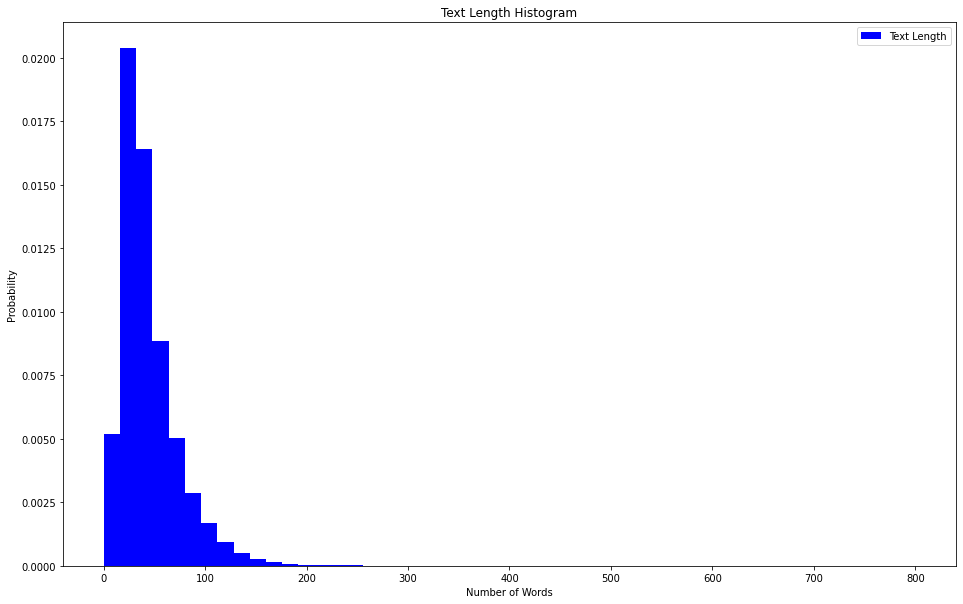

In [46]:
plt.figure(figsize=(16,10))
plt.hist(texts_len, bins=50, range=[0,800], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

**6.4 각 NER 태그별 데이터에 포함된 갯수**

In [50]:
for tag in list(tag2id.keys()) : 
    globals()[tag] = 0

In [51]:
for tag in tags : 
    for ner in tag : 
        globals()[ner] += 1

In [52]:
for tag in list(tag2id.keys()) : 
    print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

 B-ORG :  53,949
 I-ORG : 207,110
     O : 4,532,021


### 7. Train Test Split

In [53]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_tags, test_tags = train_test_split(texts, tags, test_size=.2, random_state=42)

In [54]:
print('Train 문장 : {:>6,}' .format(len(train_texts)))
print('Train 태그 : {:>6,}' .format(len(train_tags)))
print('Test  문장 : {:>6,}' .format(len(test_texts)))
print('Test  태그 : {:>6,}' .format(len(test_tags)))

Train 문장 : 87,410
Train 태그 : 87,410
Test  문장 : 21,853
Test  태그 : 21,853


In [55]:
train_texts[5]

['첫',
 '출',
 '발',
 '남',
 '상',
 '은',
 '작',
 '은',
 '어',
 '간',
 '하',
 '나',
 '였',
 '어',
 '요',
 '.']

### 8. BERT 토크나이저

- KcELECTRA외에 다른 언어모델들은 성능이 오락가락해서 사용하지 않음
- 하지만 성능이 매우 낮게 나오는 것에 비해 추론시 생각보다 괜찮은 것 같아서 테스트 진행 예정

In [73]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

In [74]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [75]:
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [76]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 바꿔줘야함

# berttokenizer를 쓸건데 여기에 들어있는 8000개 밖에 안되는 한국어가 들어있지만 많은수가 음절이다.
# 한국어들의 거의 음절로 존재. -> 음절 단위 tokenizer를 적용해도 vocab id를 어느 정도 획득할 수 있음.
# 그래서 음절로 쪼개면 UNK가 별로 없을 것이다.

def ner_tokenizer(sent, max_seq_length):    
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1
    
    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [77]:
print(ner_tokenizer(train_texts[0], 5))
# 'token_type_ids': [0, 0, 0, 0, 0] 은 segmentA로 0000으로 되어있는거.

{'input_ids': [2, 1912, 4044, 4040, 3], 'attention_mask': [1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0]}


In [78]:
tokenized_train_sentences = []
tokenized_test_sentences = []

for text in train_texts:    # 전체 데이터를 tokenizing 합니다.
    tokenized_train_sentences.append(ner_tokenizer(text, 128))
for text in test_texts:
    tokenized_test_sentences.append(ner_tokenizer(text, 128))

In [79]:
# 우리의 label도 truncation과 tokenizing이 필요하다.
def encode_tags(tags, max_seq_length):
    # label 역시 입력 token과 개수를 맞춰줍니다
    tags = tags[:max_seq_length-2]
    labels = [tag2id[tag] for tag in tags]
    labels = [tag2id['O']] + labels

    padding_length = max_seq_length - len(labels)
    labels = labels + ([pad_token_label_id] * padding_length)

    return labels

In [80]:
tag2id

{'B-ORG': 0, 'I-ORG': 1, 'O': 2}

In [81]:
encode_tags(train_tags[0], 5)

[2, 2, 2, 2, 2]

In [82]:
train_labels = []
test_labels = []

for tag in train_tags:
    train_labels.append(encode_tags(tag, 128))

for tag in test_tags:
    test_labels.append(encode_tags(tag, 128))

In [83]:
len(train_labels), len(test_labels)

(87410, 21853)

### 9. Token 데이터셋

In [84]:
import torch

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TokenDataset(tokenized_train_sentences, train_labels)
test_dataset = TokenDataset(tokenized_test_sentences, test_labels)

In [85]:
# BertForSencenceClassification이 아니다! token이 목적이다.
from transformers import BertForTokenClassification, Trainer, TrainingArguments, AutoModelForTokenClassification,EarlyStoppingCallback
import sys
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000, # 1000번쨰 steps마다 log를 보여줌 
    learning_rate=3e-5,
    weight_decay=0.01,
    save_total_limit=5,
    save_strategy='steps', # steps로 해야 earlystop이 가능
    evaluation_strategy='steps',
    save_steps=1000, # 1000번쨰 step마다 저장
    eval_steps=1000, # 1000번째 step마다 평가
    seed=15,
    load_best_model_at_end=True # 가장 좋은 성능의 모델로...
)

### 10. BertForTokenClassification

In [86]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(unique_tags))
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,# evaluation dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] #loss가 2번 감소하지 않으면 스탑
)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.weight', 'classifier.bias']

In [87]:
import gc
gc.collect()

221

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
1000,0.083800,0.078732,24.660200,886.163000
2000,0.046500,0.034707,24.646800,886.648000
3000,0.035200,0.028771,24.680000,885.456000
4000,0.031700,0.025202,24.634100,887.103000
5000,0.026000,0.020598,24.744900,883.131000
6000,0.024200,0.023487,24.697200,884.838000
7000,0.022100,0.017328,24.720900,883.990000
8000,0.020300,0.021837,24.686800,885.208000
9000,0.017800,0.013997,24.711700,884.319000
10000,0.017300,0.012812,24.595400,888.500000


In [106]:
trainer.evaluate()

{'eval_loss': 0.009723762050271034,
 'eval_runtime': 27.226,
 'eval_samples_per_second': 802.653,
 'epoch': 1.56,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 277207040}

In [101]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(21853, 128, 3) (21853, 128)


In [102]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [103]:
index_to_ner = {i:j for j, i in tag2id.items()}
f_label = [i for i, j in tag2id.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(predictions.label_ids).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(preds).astype(int).tolist()]

In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [105]:
#데이터셋 추가
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-ORG       0.92      0.96      0.94     10599
       I-ORG       0.93      0.98      0.96     40510
           O       1.00      1.00      1.00   2746075

    accuracy                           1.00   2797184
   macro avg       0.95      0.98      0.96   2797184
weighted avg       1.00      1.00      1.00   2797184



In [110]:
#이전
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-ORG       0.95      0.96      0.96      2461
           O       1.00      1.00      1.00    481177
       I-ORG       0.96      0.98      0.97      9546

    accuracy                           1.00    493184
   macro avg       0.97      0.98      0.97    493184
weighted avg       1.00      1.00      1.00    493184



In [107]:
trainer.save_model('kcelectra_base_new')

In [111]:
# 저장한 모델 불러오기
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tag2id = {'B-ORG': 0, 'I-ORG': 1, 'O': 2}
unique_tags={'B-ORG', 'I-ORG', 'O'}
id2tag={0: 'B-ORG', 1: 'I-ORG', 2: 'O'}
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

model = AutoModelForTokenClassification.from_pretrained('kcelectra_base_new', num_labels=len(unique_tags))
model.to(device)

ElectraForTokenClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [ ]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 변경

# berttokenizer를 사용하는데 한국어 vocab이 8000개 정도 밖에 없고 그 안의 한국어들의 거의 음절로 존재
# -> 음절 단위 tokenizer를 적용하면 vocab id를 어느 정도 획득할 수 있어 UNK가 별로 없을듯 하다
def ner_tokenizer(sent, max_seq_length):    
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1
    
    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [116]:
def ner_inference(text) : 
  
    model.eval()
    text = text.replace(' ', '_')

    predictions , true_labels = [], []
    
    tokenized_sent = ner_tokenizer(text, len(text)+2)
    input_ids = torch.tensor(tokenized_sent['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_sent['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(tokenized_sent['token_type_ids']).unsqueeze(0).to(device)    
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
    logits = outputs['logits']
    logits = logits.detach().cpu().numpy()
    label_ids = token_type_ids.cpu().numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)

    pred_tags = [list(tag2id.keys())[p_i] for p in predictions for p_i in p]

    print('{}\t{}'.format("TOKEN", "TAG"))
    print("===========")
    # for token, tag in zip(tokenizer.decode(tokenized_sent['input_ids']), pred_tags):
    #   print("{:^5}\t{:^5}".format(token, tag))
    for i, tag in enumerate(pred_tags):
        print("{:^5}\t{:^5}".format(tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids'][i]), tag))


In [117]:
text = '종목별로는  미래에셋증권(+2.83%)  메리츠증권(+3.99%)  한국금융지주(+3.07%)  삼성증권(+2.67%)  NH투자증권(+2.08)  키움증권(+4.06%) 등이 강세를 보였다. KRX 증권 지수는 증시에 상장된 증권업종의 주가 흐름을 반영하는 지수로 미래에셋증권, 한국금융지주, NH투자증권 등 14개 종목이 지수에 포함돼 있다. 증권정보업체 에프앤가이드에 따르면 실적추정치가 있는 증권사 다섯 군데(삼성증권, 미래에셋증권, 키움증권, 한국금융지주, NH투자증권)의 4분기 영업이익 전망치 합은 8558억 원으로 전년 동기보다 27.60% 줄어들 전망이다.'

In [118]:
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  종  	  O  
 ##목 	  O  
 ##별 	  O  
 ##로 	  O  
 ##는 	  O  
  _  	  O  
  _  	  O  
  미  	B-ORG
 ##래 	I-ORG
 ##에 	I-ORG
 ##셋 	I-ORG
 ##증 	I-ORG
 ##권 	I-ORG
[UNK]	  O  
[UNK]	  O  
 ##2 	  O  
[UNK]	  O  
 ##8 	  O  
 ##3 	  O  
[UNK]	  O  
[UNK]	  O  
  _  	  O  
  _  	  O  
  메  	B-ORG
 ##리 	I-ORG
 ##츠 	I-ORG
 ##증 	I-ORG
 ##권 	I-ORG
[UNK]	  O  
[UNK]	  O  
 ##3 	  O  
[UNK]	  O  
 ##9 	  O  
 ##9 	  O  
[UNK]	  O  
[UNK]	  O  
  _  	  O  
  _  	  O  
  한  	B-ORG
 ##국 	I-ORG
 ##금 	I-ORG
 ##융 	I-ORG
 ##지 	I-ORG
 ##주 	I-ORG
[UNK]	  O  
[UNK]	  O  
 ##3 	  O  
[UNK]	  O  
 ##0 	  O  
 ##7 	  O  
[UNK]	  O  
[UNK]	  O  
  _  	  O  
  _  	  O  
  삼  	B-ORG
 ##성 	I-ORG
 ##증 	I-ORG
 ##권 	I-ORG
[UNK]	  O  
[UNK]	  O  
 ##2 	  O  
[UNK]	  O  
 ##6 	  O  
 ##7 	  O  
[UNK]	  O  
[UNK]	  O  
  _  	  O  
  _  	  O  
  N  	B-ORG
 ##H 	I-ORG
 ##투 	I-ORG
 ##자 	I-ORG
 ##증 	I-ORG
 ##권 	I-ORG
[UNK]	  O  
[UNK]	  O  
 ##2 	  O  
[UNK]	  O  
 ##0 	  O  
 ##8 	  O  
[UNK]	  O  
  _  	

In [119]:
text = '중국의 리오프닝 본격화와 국내 실내 마스크 해제 조치 기대감에 LG생활건강(051900), 아모레퍼시픽(090430) 등은 5%대 뛰었다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  중  	  O  
 ##국 	  O  
 ##의 	  O  
  _  	  O  
  리  	  O  
 ##오 	  O  
 ##프 	  O  
 ##닝 	  O  
  _  	  O  
  본  	  O  
 ##격 	  O  
 ##화 	  O  
 ##와 	  O  
  _  	  O  
  국  	  O  
 ##내 	  O  
  _  	  O  
  실  	  O  
 ##내 	  O  
  _  	  O  
  마  	  O  
 ##스 	  O  
 ##크 	  O  
  _  	  O  
  해  	  O  
 ##제 	  O  
  _  	  O  
  조  	  O  
 ##치 	  O  
  _  	  O  
  기  	  O  
 ##대 	  O  
 ##감 	  O  
 ##에 	  O  
  _  	  O  
  L  	B-ORG
 ##G 	I-ORG
 ##생 	I-ORG
 ##활 	I-ORG
 ##건 	I-ORG
 ##강 	I-ORG
[UNK]	  O  
 ##0 	  O  
 ##5 	  O  
 ##1 	  O  
 ##9 	  O  
 ##0 	  O  
 ##0 	  O  
[UNK]	  O  
[UNK]	  O  
  _  	  O  
  아  	B-ORG
 ##모 	I-ORG
 ##레 	I-ORG
 ##퍼 	I-ORG
 ##시 	I-ORG
 ##픽 	I-ORG
[UNK]	  O  
 ##0 	  O  
 ##9 	  O  
 ##0 	  O  
 ##4 	  O  
 ##3 	  O  
 ##0 	  O  
[UNK]	  O  
  _  	  O  
  등  	  O  
 ##은 	  O  
  _  	  O  
  5  	  O  
[UNK]	  O  
 ##대 	  O  
  _  	  O  
  뛰  	  O  
 ##었 	  O  
 ##다 	  O  
[UNK]	  O  
[SEP]	  O  


In [120]:
text = '엔씨소프트 개발차 출신 김동신 대표가 미국에 창업한 센드버드는 채팅 서비스 플랫폼 업체로 미국의 핀테크 업체 페이팔, 약국 체인 월그린 등 1200여 곳의 고객사를 확보하는 등 해외 시장을 장악하고 있다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  엔  	B-ORG
 ##씨 	I-ORG
 ##소 	I-ORG
 ##프 	I-ORG
 ##트 	I-ORG
  _  	  O  
  개  	  O  
 ##발 	  O  
 ##차 	  O  
  _  	  O  
  출  	  O  
 ##신 	  O  
  _  	  O  
  김  	  O  
 ##동 	  O  
 ##신 	  O  
  _  	  O  
  대  	  O  
 ##표 	  O  
 ##가 	  O  
  _  	  O  
  미  	  O  
 ##국 	  O  
 ##에 	  O  
  _  	  O  
  창  	  O  
 ##업 	  O  
 ##한 	  O  
  _  	  O  
  센  	  O  
 ##드 	  O  
 ##버 	  O  
 ##드 	  O  
 ##는 	  O  
  _  	  O  
  채  	  O  
 ##팅 	  O  
  _  	  O  
  서  	  O  
 ##비 	  O  
 ##스 	  O  
  _  	  O  
  플  	  O  
 ##랫 	  O  
 ##폼 	  O  
  _  	  O  
  업  	  O  
 ##체 	  O  
 ##로 	  O  
  _  	  O  
  미  	  O  
 ##국 	  O  
 ##의 	  O  
  _  	  O  
  핀  	  O  
 ##테 	  O  
 ##크 	  O  
  _  	  O  
  업  	  O  
 ##체 	  O  
  _  	  O  
  페  	  O  
 ##이 	  O  
 ##팔 	  O  
[UNK]	  O  
  _  	  O  
  약  	  O  
 ##국 	  O  
  _  	  O  
  체  	  O  
 ##인 	  O  
  _  	  O  
  월  	  O  
 ##그 	  O  
 ##린 	  O  
  _  	  O  
  등  	  O  
  _  	  O  
  1  	  O  
 ##2 	  O  
 ##0 	  O  
 ##0 	

In [122]:
text = '셀트리온그룹은 지난해 셀트리온홀딩스와 셀트리온헬스케어홀딩스의 합병을 마무리하고 셀트리온·셀트리온헬스케어·셀트리온제약의 3사 합병을 추진 중이다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  셀  	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
 ##그 	  O  
 ##룹 	I-ORG
 ##은 	  O  
  _  	  O  
  지  	  O  
 ##난 	  O  
 ##해 	  O  
  _  	  O  
  셀  	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
 ##홀 	I-ORG
 ##딩 	I-ORG
 ##스 	I-ORG
 ##와 	  O  
  _  	  O  
  셀  	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
 ##헬 	I-ORG
 ##스 	I-ORG
 ##케 	I-ORG
 ##어 	I-ORG
 ##홀 	I-ORG
 ##딩 	I-ORG
 ##스 	I-ORG
 ##의 	  O  
  _  	  O  
  합  	  O  
 ##병 	  O  
 ##을 	  O  
  _  	  O  
  마  	  O  
 ##무 	  O  
 ##리 	  O  
 ##하 	  O  
 ##고 	  O  
  _  	  O  
  셀  	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
[UNK]	  O  
 ##셀 	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
 ##헬 	I-ORG
 ##스 	I-ORG
 ##케 	I-ORG
 ##어 	I-ORG
[UNK]	  O  
 ##셀 	B-ORG
 ##트 	I-ORG
 ##리 	I-ORG
 ##온 	I-ORG
 ##제 	I-ORG
 ##약 	I-ORG
 ##의 	  O  
  _  	  O  
  3  	  O  
 ##사 	  O  
  _  	  O  
  합  	  O  
 ##병 	  O  
 ##을 	  O  
  _  	  O  
  추  	  O  
 ##진 	  O  
  _  	  O  
  중  	  O  
 ##이 	  O  
 ##다 	  O  
[UNK]	  O  
[SEP]	  O  


In [125]:
text = '롯데관광개발(032350)은 지난 15일 롯데홈쇼핑에서 진행한 ‘북유럽 비즈니스 패키지’가 1시간 만에 3250콜이 몰려 약 270억원의 매출을 올렸다고 16일 밝혔다. 권기경 롯데관광개발 여행사업본부장은 "COVID-19로 인해 그동안 억눌려왔던 해외 여행 수요가 폭발하고 있는데다 고가의 프리미엄 패키지에 대한 고객들의 믿음 덕분”이라고 말했다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  롯  	B-ORG
 ##데 	I-ORG
 ##관 	I-ORG
 ##광 	I-ORG
 ##개 	I-ORG
 ##발 	I-ORG
[UNK]	  O  
 ##0 	  O  
 ##3 	  O  
 ##2 	  O  
 ##3 	  O  
 ##5 	  O  
 ##0 	  O  
[UNK]	  O  
 ##은 	  O  
  _  	  O  
  지  	  O  
 ##난 	  O  
  _  	  O  
  1  	  O  
 ##5 	  O  
 ##일 	  O  
  _  	  O  
  롯  	B-ORG
 ##데 	I-ORG
 ##홈 	I-ORG
 ##쇼 	I-ORG
 ##핑 	I-ORG
 ##에 	  O  
 ##서 	  O  
  _  	  O  
  진  	  O  
 ##행 	  O  
 ##한 	  O  
  _  	  O  
  ‘  	  O  
 ##북 	  O  
 ##유 	  O  
 ##럽 	  O  
  _  	  O  
  비  	  O  
 ##즈 	  O  
 ##니 	  O  
 ##스 	  O  
  _  	  O  
  패  	  O  
 ##키 	  O  
 ##지 	  O  
[UNK]	  O  
 ##가 	  O  
  _  	  O  
  1  	  O  
 ##시 	  O  
 ##간 	  O  
  _  	  O  
  만  	  O  
 ##에 	  O  
  _  	  O  
  3  	  O  
 ##2 	  O  
 ##5 	  O  
 ##0 	  O  
 ##콜 	  O  
 ##이 	  O  
  _  	  O  
  몰  	  O  
 ##려 	  O  
  _  	  O  
  약  	  O  
  _  	  O  
  2  	  O  
 ##7 	  O  
 ##0 	  O  
 ##억 	  O  
 ##원 	  O  
 ##의 	  O  
  _  	  O  
  매  	  O  
 ##출 	  O  
 ##을 	  O  
  _  	  O  
  올  	